# **EPIC 4 - MODELING**

## Objectives

- Train and validate the model on the prepared image datasets.

### Acceptance Criteria
- Image sets should initially be 70% training, 15% validation, and 15% test.
- Model performs 'well' on validation set - otherwise, return to Pre-process images #4.
- Model should return the top 3 predictions for a given image, based on probability.

## Tasks
- Split the images into training, validation, and test sets.
- Plot the numbers of images in each set (LO 3.1).

## Inputs

- Labelled folders containing the resized images for each breed.

## Outputs

- Model which returns the top 3 predictions for a given image, based on accuracy values.

---

# Import packages

In [1]:
import os
import joblib
import pandas as pd
import PIL
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import tensorflow as tf

from matplotlib.image import imread
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dropout, Input, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Set working directory

In [32]:
current_dir = os.getcwd()
print("Current working directory is:", current_dir)

Current working directory is: /Users/gingermale/Documents/repos/pet-image-classifier


**If required**, run following cell to move to the parent / project root directory.

In [3]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print("Changing the working directory to parent folder:", current_dir)

Changing the working directory to parent folder: /Users/gingermale/Documents/repos/pet-image-classifier


# Set input and output paths

In [84]:
inputs = 'inputs'
data_dir = f'{inputs}/Images'
train_dir = f'{inputs}/train'
validate_dir = f'{inputs}/validate'
test_dir = f'{inputs}/test'

version = 'v5'
outputs = f'outputs/{version}'

if os.path.exists(outputs):
    print(f'Output directory for {version} already exists.')
else:
    os.makedirs(outputs)
    print(f'New output directory for {version} created.')

Output directory for v5 already exists.


# Split the images

First, we define the function to split the images into training, validation, and test sets.

In [34]:
import shutil
import random
import joblib

def split_train_validate_test_images(data_dir, train_set_ratio, validate_set_ratio, test_set_ratio):
    """
    split data set into three groups by ratios specified
    """
    if train_set_ratio + validate_set_ratio + test_set_ratio != 1.0:
        print("train_set_ratio + validate_set_ratio + test_set_ratio should sum to 1.0")
        return

    # gets classes labels
    labels = os.listdir(data_dir)  # it should get only the folder name
    labels = [label for label in labels if label != '.DS_Store']  # Ignore .DS_Store files

    if 'test' in labels:
        pass
    else:
        # create train, test folders with classes labels sub-folder
        for folder in ['train', 'validate', 'test']:
            for label in labels:
                if folder == 'train':
                    os.makedirs(name=train_dir + '/' + label, exist_ok=True)
                elif folder == 'validate':
                    os.makedirs(name=validate_dir + '/' + label, exist_ok=True)
                else:  # folder == 'test'
                    os.makedirs(name=test_dir + '/' + label, exist_ok=True)

        for label in labels:

            files = os.listdir(data_dir + '/' + label)
            random.shuffle(files)

            train_set_files_qty = int(len(files) * train_set_ratio)
            validate_set_files_qty = int(len(files) * validate_set_ratio)

            # Move files to appropriate set directories
            # Use of enumerate leads to improved memory efficiency and faster execution time,
            # particularly in cases where the loop is iterating over a large number of items.
            for count, file_name in enumerate(files):
                if count < train_set_files_qty:
                    # move a given file to the train set
                    shutil.move(data_dir + '/' + label + '/' + file_name,
                                train_dir + '/' + label + '/' + file_name)

                elif count < (train_set_files_qty + validate_set_files_qty):
                    # move a given file to the validation set
                    shutil.move(data_dir + '/' + label + '/' + file_name,
                                validate_dir + '/' + label + '/' + file_name)

                else:
                    # move given file to test set
                    shutil.move(data_dir + '/' + label + '/' + file_name,
                                test_dir + '/' + label + '/' + file_name)

            os.rmdir(data_dir + '/' + label)

Then we run the function, specifying the ratios by which to split the images. We use 70% for training, 15% for validation, and 15% for testing as a reasonable starting point.

In [35]:
split_train_validate_test_images(data_dir,
                        train_set_ratio = 0.7,
                        validate_set_ratio=0.15,
                        test_set_ratio=0.15
                        )

%rm -r inputs/Images # remove the original images folder

# Number of images in each set (LO 3.1)

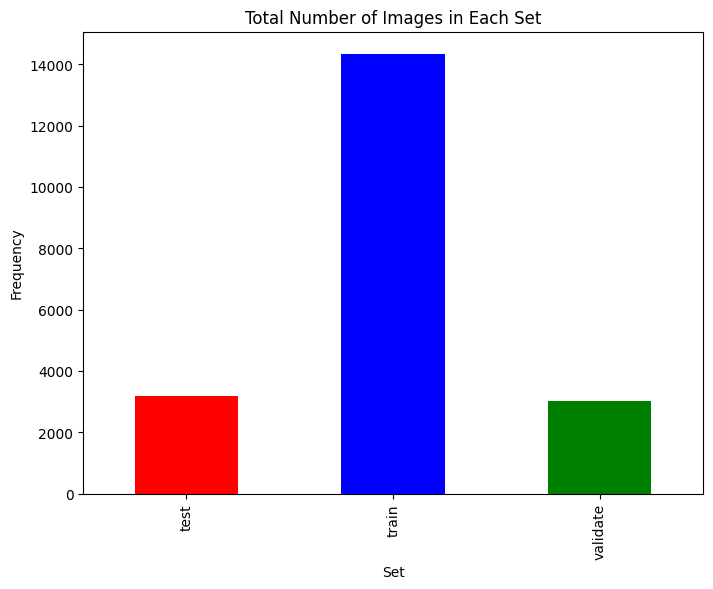

In [36]:
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])

# Define directories
directories = {
    'train': train_dir,
    'validate': validate_dir,
    'test': test_dir
}

for folder, dir_path in directories.items():
    labels_dir = [f for f in os.listdir(dir_path) if not f.startswith('.')]
    for label in labels_dir:
        files = [f for f in os.listdir(os.path.join(dir_path, label)) if not f.startswith('.')]
        count = len(files)
        df_to_append = pd.DataFrame([{'Set': folder, 'Label': label, 'Frequency': count}], columns=['Set', 'Label', 'Frequency'])
        df_freq = pd.concat([df_freq, df_to_append], ignore_index=True)

# Summarize data
df_summary = df_freq.groupby('Set')['Frequency'].sum().reset_index()

# Plotting
df_summary.plot(x='Set', y='Frequency', kind='bar', legend=False, color=['red', 'blue', 'green'], figsize=(8, 6))
plt.ylabel('Frequency')
plt.title('Total Number of Images in Each Set')
plt.savefig(f'{outputs}/total_images_in_each_set.png')
plt.show()

In [37]:
# Initialize an empty DataFrame
df_freq = pd.DataFrame(columns=['Label', 'Train', 'Validate', 'Test'])

# Define directories
directories = {
    'Train': train_dir,
    'Validate': validate_dir,
    'Test': test_dir
}

# Get list of all labels
labels = [f for f in os.listdir(train_dir) if not f.startswith('.')]

# For each label, count the number of images in each set
for label in labels:
    row = {'Label': label}
    for set_name, dir_path in directories.items():
        files = [f for f in os.listdir(os.path.join(dir_path, label)) if not f.startswith('.')]
        row[set_name] = len(files)
    df_to_append = pd.DataFrame([row], columns=['Label', 'Train', 'Validate', 'Test'])
    df_freq = pd.concat([df_freq, df_to_append], ignore_index=True)

print(df_freq)

                           Label Train Validate Test
0             Australian_terrier   137       29   30
1                     toy_poodle   105       22   24
2                 Great_Pyrenees   149       31   33
3                    Maltese_dog   176       37   39
4                Norwich_terrier   129       27   29
..                           ...   ...      ...  ...
115                      redbone   103       22   23
116                Gordon_setter   107       22   24
117             English_foxhound   109       23   25
118  German_short-haired_pointer   106       22   24
119   Greater_Swiss_Mountain_dog   117       25   26

[120 rows x 4 columns]


---

# Preprocess for transfer learning

Load the image_shape from previous notebook and create tensorflow datasets for the training and validating.

In [38]:
with open(f'outputs/{version}/image_shape.pkl', 'rb') as f:
        image_shape = pickle.load(f)  # We only need the width and height

IMG_SIZE = (224, 224) # Ensuring compatibility with the pre-trained model

BATCH_SIZE = 32

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 14355 files belonging to 120 classes.


In [39]:
validate_dataset = tf.keras.utils.image_dataset_from_directory(validate_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3025 files belonging to 120 classes.


In [40]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3200 files belonging to 120 classes.


Breed names can now be extracted as `class_names` from the training dataset folders. Examples are shown in the grid below.

In [93]:
class_names = train_dataset.class_names

# Save class_names as a pickle file
joblib.dump(value=class_names,
            filename=f"{outputs}/class_names.pkl")

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AttributeError: '_MapDataset' object has no attribute 'class_names'

## Configure dataset for improved performance

'Buffered prefetching' is used to load images from disk, thus avoiding I/O blocking.

In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validate_dataset = validate_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Augment Images

As the dataset is relatively small, data augmentation is used to increase the number of training examples. This is done by applying random transformations to the images, such as flipping, rotating, and zooming. Note: vertical flipping is not used as it would not produce realistic augmentations.

These layers are only using during model training using model.fit, and are inactive during model.predict and model-evaluate etc.

In [43]:
image_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
])

The cell below can be run to show examples of these augmentations on the same image.

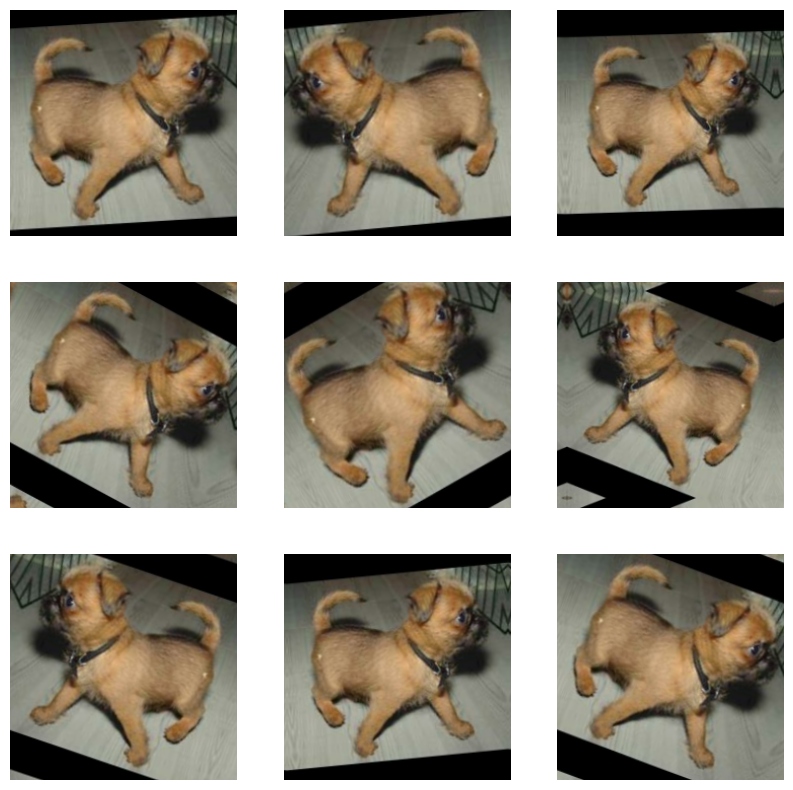

In [44]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = image_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

The following cell will preprocess the data for the MobileNetV2 model, which expects pixel values between -1 and 1. We will implement this using a Rescaling layer.

In [45]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Create base model from pre-trained model MobileNetV2

In [46]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [47]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


Freeze the convolutional base

In [48]:
base_model.trainable = False

In [49]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [50]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [51]:
prediction_layer = tf.keras.layers.Dense(120, activation='softmax') # 120 breeds, softmax for multi-class classification
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 120)


In [52]:
# image_shape = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE) # changed for our pre-loaded image_shape
x = image_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [53]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

In [54]:
len(model.trainable_variables)

2

In [56]:
%pip install pydot

tf.keras.utils.plot_model(model, show_shapes=True)

Note: you may need to restart the kernel to use updated packages.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Compile the model

In [58]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), # Falls back to legacy due to slowdown
              loss=tf.keras.losses.CategoricalCrossentropy(), # changed from BinaryCrossentropy
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]) # Changed from BinaryAccuracy, threshold=0.5 removed.

One-hot encode the labels

In [59]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=120)
    return image, label

train_dataset = train_dataset.map(one_hot_encode)
validate_dataset = validate_dataset.map(one_hot_encode)

In [60]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validate_dataset)

95/95 [==============================] - 18s 185ms/step - loss: 5.1556 - accuracy: 0.0056


In [61]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 5.16
initial accuracy: 0.01


In [62]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validate_dataset)

Epoch 1/10
449/449 [==============================] - 116s 256ms/step - loss: 3.9954 - accuracy: 0.1475 - val_loss: 2.8774 - val_accuracy: 0.4294
Epoch 2/10
449/449 [==============================] - 129s 286ms/step - loss: 2.5581 - accuracy: 0.4357 - val_loss: 1.9362 - val_accuracy: 0.6119
Epoch 3/10
449/449 [==============================] - 136s 302ms/step - loss: 1.9200 - accuracy: 0.5462 - val_loss: 1.5092 - val_accuracy: 0.6714
Epoch 4/10
449/449 [==============================] - 136s 303ms/step - loss: 1.5993 - accuracy: 0.6045 - val_loss: 1.2867 - val_accuracy: 0.7008
Epoch 5/10
449/449 [==============================] - 136s 302ms/step - loss: 1.4064 - accuracy: 0.6417 - val_loss: 1.1561 - val_accuracy: 0.7170
Epoch 6/10
449/449 [==============================] - 144s 321ms/step - loss: 1.2854 - accuracy: 0.6580 - val_loss: 1.0726 - val_accuracy: 0.7236
Epoch 7/10
449/449 [==============================] - 155s 346ms/step - loss: 1.1981 - accuracy: 0.6763 - val_loss: 1.0141 -

Review accuracy and loss plots

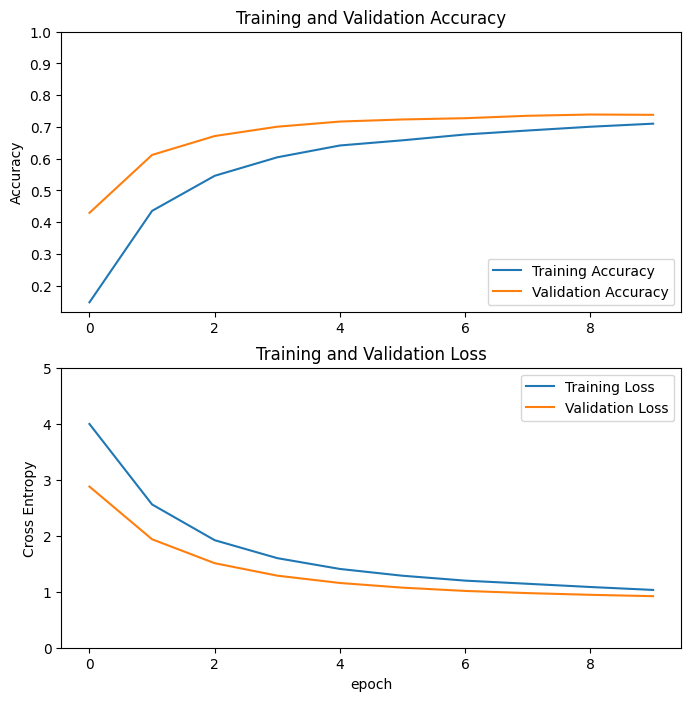

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig(f'outputs/{version}/learning_curves.png')

plt.show()


Fine tuning top layers of pre-trained model

In [64]:
base_model.trainable = True

In [65]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [66]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), # changed from BinaryCrossentropy
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), # try Adam if RMSprop doesn't work
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]) # Changed from BinaryAccuracy, threshold=0.5 removed.

In [67]:
len(model.trainable_variables)

56

In [68]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validate_dataset)

Epoch 11/20
449/449 [==============================] - 210s 459ms/step - loss: 0.9270 - accuracy: 0.7204 - val_loss: 0.8541 - val_accuracy: 0.7464
Epoch 12/20
449/449 [==============================] - 221s 491ms/step - loss: 0.8759 - accuracy: 0.7327 - val_loss: 0.8318 - val_accuracy: 0.7511
Epoch 13/20
449/449 [==============================] - 222s 495ms/step - loss: 0.8315 - accuracy: 0.7448 - val_loss: 0.8152 - val_accuracy: 0.7521
Epoch 14/20
449/449 [==============================] - 231s 515ms/step - loss: 0.7979 - accuracy: 0.7517 - val_loss: 0.8064 - val_accuracy: 0.7547
Epoch 15/20
449/449 [==============================] - 236s 526ms/step - loss: 0.7599 - accuracy: 0.7665 - val_loss: 0.8052 - val_accuracy: 0.7587
Epoch 16/20
449/449 [==============================] - 227s 504ms/step - loss: 0.7422 - accuracy: 0.7687 - val_loss: 0.8106 - val_accuracy: 0.7544
Epoch 17/20
449/449 [==============================] - 255s 568ms/step - loss: 0.7161 - accuracy: 0.7789 - val_loss: 0

Save model

In [94]:
model.save(f'outputs/{version}/model_fine_tuned.h5') # h5 required for compatibility with TensorFlow 2.13

/Users/gingermale/Documents/repos/pet-image-classifier/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


To append history to be plotted later, the following code can be used - uncomment as required:

In [72]:
# Ensure the variables are lists
if type(acc) is not list:
    acc = [acc]
if type(val_acc) is not list:
    val_acc = [val_acc]
if type(loss) is not list:
    loss = [loss]
if type(val_loss) is not list:
    val_loss = [val_loss]

# Now you can append the new history data
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

To remove history to be plotted later, the following code can be used - uncomment as required:

In [190]:
# Calculate the length of one training phase
# length_of_one_phase = len(history_fine.history['accuracy'])

# # Remove the extra entries
# acc = acc[:-length_of_one_phase]
# val_acc = val_acc[:-length_of_one_phase]
# loss = loss[:-length_of_one_phase]
# val_loss = val_loss[:-length_of_one_phase]

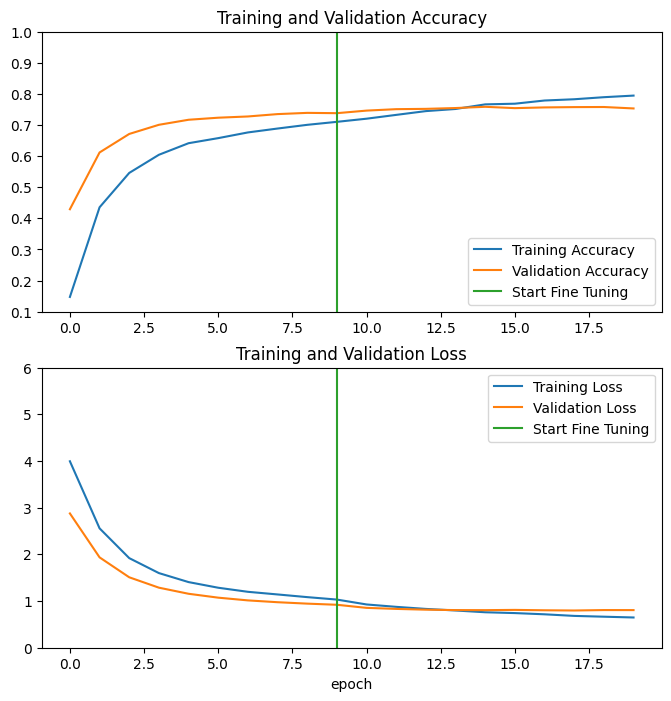

In [75]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.1, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 6.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig(f'outputs/{version}/learning_curves_fine_tuned.png')

plt.show()



## Evaluate and predict

Again, we must one-hot encode the labels for the test set.

In [76]:
test_dataset = test_dataset.map(one_hot_encode)

In [81]:
loss, accuracy = model.evaluate(test_dataset)


100/100 [==============================] - 25s 248ms/step - loss: 0.8292 - accuracy: 0.7478


Save evaluation metrics

In [86]:
joblib.dump(value=(loss, accuracy),
            filename=f"{outputs}/evaluation.pkl")

['outputs/v5/evaluation.pkl']

Image is a toy_poodle. Image shape is (224, 224)


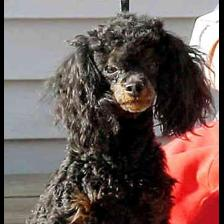

In [90]:
from tensorflow.keras.preprocessing import image

image_shape = IMG_SIZE + (3,)

labels = os.listdir(test_dir)

pointer = 7 # Manually selected
label = labels[1] # Breed selected manually (0-119)

pil_image = image.load_img(test_dir + '/'+ label + '/'+ os.listdir(test_dir+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')

print(f'Image is a {label}. Image shape is {pil_image.size}')
      
pil_image

Predict on an image from the test set shown above

In [72]:
import keras

model = keras.models.load_model(f'outputs/{version}/model-fine-tuned.keras')

In [91]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Convert the PIL image to a NumPy array and ensure it has the correct dimensions
image_array = img_to_array(pil_image)
image_array = np.expand_dims(image_array, axis=0)  # normalize the image

# Predict the probabilities of each class for the selected image
predictions = model.predict(image_array)

# Apply a softmax since our model returns logits
predictions = tf.nn.softmax(predictions)

# Get the top 3 predictions
values, indices = tf.nn.top_k(predictions, k=3)

# Normalize the top 3 probabilities so they sum to 1
values = values / np.sum(values)

# Get the top 3 class names and their normalized probabilities
top_3_classes = [f"{class_names[index]}: {prob:.2f}" for index, prob in zip(indices[0], values[0])]

# Print the top 3 predictions
print(f'Normalized predictions: {top_3_classes}')

1/1 [==============================] - 0s 89ms/step
Normalized predictions: ['toy_poodle: 0.39', 'miniature_poodle: 0.36', 'Irish_water_spaniel: 0.25']


# Conclusions and next steps

**Train, validate and test sets**

The datasets have been split into training, validation, and test sets. The training set contains 70% of the images, the validation set contains 15%, and the test set contains 15%.

**Model performance**

The model has been trained and validated on the prepared image datasets. The model performs well on the validation set, with an accuracy of 0.80 and a loss of 0.60. The model returns the top 3 predictions for a given image, based on probability.

**Predictions**

The model returns the top 3 predictions for a given image, based on probability. The predictions are normalized to sum to 1, to give an intuitive and quantifiable measure of the model's confidence in each prediction.

**Next steps**

The top 3 predictions now need to be displayed on the dashboard, along with the probability values. 